BioVida: Open-i
========

Open-i is an open access biomedical search engine provided courtesy of the US National Institutes of Health.
BioVida provides an easy-to-use interface for harvesting and cleaning data from this source, located in the ``images`` subpackage.

In [1]:
import qgrid
from utils import qshow
qgrid.nbinstall(overwrite=True)

Note: `utils` is a small script with some helpful functions located in the base of this directory. 

In [2]:
from biovida.images import OpeniInterface

Using Theano backend.


We start by creating an instance of the class. All BioVida interfaces accept at least two parameters: `verbose` and `cache_path`. The first simply determines whether or not the class provides you with additional updates as files are downloaded, for example. The second refers to the location where downloaded data, like images, will be stored (or *cached*) on your computer. If left to its default, images will be cached in a directory entitled *biovida_cache* in your home directory. For most use cases, this should suffice.


In [3]:
opi = OpeniInterface()

Next, we may want to perform a simple search of the Open-i database. For ``OpeniInterface``, this is done using a simple ``search`` method. To explore valid values that can be passed to ``search``, we can use the ``options`` method.

---

### Searching

In [4]:
opi.options()

  - 'article_type'
  - 'collection'
  - 'exclusions'
  - 'fields'
  - 'image_type'
  - 'rankby'
  - 'specialties'
  - 'subset'
  - 'video'


This enumerates all of the parameters, apart from a specific ``query`` string, that can be passed to ``search()``. <br>
To investigate the specific value a given ``search()`` parameter accepts, we can simply pass the it to ``options()``.

In [5]:
opi.options('collection')

  - 'history_of_medicine'
  - 'indiana_u_xray'
  - 'medpix'
  - 'pubmed'
  - 'usc_anatomy'


In [6]:
opi.options('image_type')

  - 'ct'
  - 'graphic'
  - 'microscopy'
  - 'mri'
  - 'pet'
  - 'photograph'
  - 'ultrasound'
  - 'x_ray'


Let's go ahead and perform a search for X-ray and CT images of 'lung cancer' from the PubMed collection/database.

In [7]:
opi.search(query='lung cancer', image_type=('x_ray', 'ct'), collection='pubmed')


Results Found: 8,531.


Next, we can download these images using ``pull()``.

---

### Downloading Data

In [8]:
pull_df = opi.pull(download_limit=1500)  # limit to the first 1500 results


Number of Records to Download: 1,500 (chunk size: 30 records).




Extracting Features from Text...




Cleaning Text Information...

Obtaining Images... 


*Note*: records (i.e., the text information) is downloaded in 'chunks' of no more than 30 at a time, whereas images are downloaded 'one by one'. If an images is already located in your cache, it will not be downloaded again.

The dataframe generated by ``pull()`` can be viewed using either ``opi.records_db``, or the ``pull_df`` used above to capture the output of ``pull()``. Both will be identical. We can also view an abbreviated dataframe, ``opi.records_db_short``, which has several (typically unneeded) columns removed. 

In [9]:
def simplify_df(df):
    """This function simplifies dataframes
    for the purposes of this tutorial."""
    data_frame = df.copy()
    for c in ('parsed_abstract', 'query'):
        data_frame[c] = data_frame[c].map(lambda x: str(x) if str(x) != 'nan' else x)
    return data_frame.drop('cached_images_path', axis=1)

In [10]:
qshow(simplify_df(opi.records_db_short))

This dataframe is provides a lot of rich data, which is valuable independent of the images which have also been downloaded. 

For instance, it is possible to quickly generate some descriptive statistics about our newly created dataset.

In [11]:
pull_df['age'].describe()

count    966.000000
mean      53.337267
std       21.999990
min        1.000000
25%       47.000000
50%       59.000000
75%       68.000000
max       91.400000
Name: age, dtype: float64

In [12]:
pull_df['sex'].value_counts(normalize=True)

male      0.722359
female    0.277641
Name: sex, dtype: float64

The `age` column in generated by analyzing the raw text provided by the Open-i API. It is reasonably accurate, but mistakes are certainly possible. <br>
Also note that 'count', above, is equal to 966 and not 1500 because Pandas is excluding missing values (`NaNs`) in the column.

It should also be mentioned that ``opi.records_db`` *only* contains data for the most recent ``search()`` and ``pull()``. Conversely, ``opi.cache_records_db`` provides a record of all images in the cache, e.g., those obtained several weeks ago.

---

### Images

Now that we've explored obtaining and reviewing data, we can finally look at working with Open-i images themselves

In [13]:
from utils import show_image
%matplotlib inline

Define a tool to view images:

We can now look at a random images we've recently pulled.

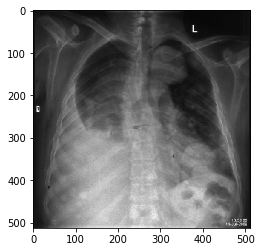

In [14]:
show_image(opi.records_db['cached_images_path'].iloc[156])

In [15]:
opi.records_db['license_type'].iloc[156]

'open-access'

Let's also look at the age and sex of this subject. 

In [16]:
age_sex = opi.records_db['age'].iloc[156], opi.records_db['sex'].iloc[156]
print("age: {0}, sex: {1}.".format(*age_sex))

age: 48.0, sex: male.


We can also easily check their diagnosis

In [17]:
opi.records_db['diagnosis'].iloc[156]

'carcinoma; neurofibromatosis'

**Note**: For collections other than 'MedPix'\*, such as PubMed, diagnosis information is obtained by analyzing the text associated with the image. *Errors are possible*.

\*MedPix explicitly provides diagnosis information, so it can be assumed to be accurate.  

---

### Refining Image Data (Experimental)

While the data may look OK so far, if we look more closely we will likely find several problems with the images we have downloaded

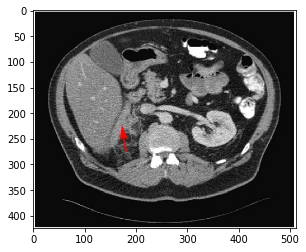

In [18]:
show_image(opi.records_db['cached_images_path'].iloc[100])

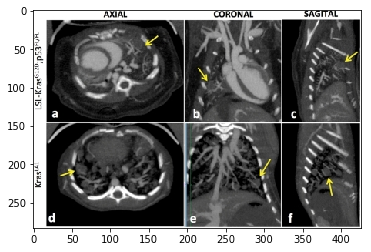

In [19]:
show_image(opi.records_db['cached_images_path'].iloc[10])

The images above contain several clear problems. They both contain arrows and the latter is actually a 'grid' of images. These are liable to confuse any model we attempt to train detect disease. We could manually go through and remove these images or, alternatively, we can use the ``OpeniImageProcessing`` class to try and eliminate these images from our dataset automatically.

In [20]:
from biovida.images import OpeniImageProcessing

We initialize this class using our ``OpeniInterface`` instance.
By default, it will extract the `records_db` DataFrame, however we can force it to extract the ``cache_records_db`` DataFrame by setting the ``db_to_extract`` equal to 'cache_records_db'.

In [21]:
ip = OpeniImageProcessing(opi)

``OpeniImageProcessing`` will automatically download a model for a *Convolutional Neural Network* (convnet) which has been trained to detect these kinds of problems. If you are unfamiliar with these kinds of models, you can read more about them [here](http://cs231n.github.io/convolutional-networks/).

The ``OpeniImageProcessing`` tries to detect problems in the images by analyzing both the text associated with the image as well as by processing the image itself using the convnet introduced above. However, this class will not use any predictions gleaned from the convnet unless it has been trained on images of that type.

We can easily check the modalities for which the model has been trained:

In [22]:
ip.trained_open_i_modality_types

['ct', 'mri', 'x_ray']

Luckily, we're working with X-rays and CTs. <br>

Now we're ready to analyze our images.

In [23]:
analysis_df = ip.auto()



Starting Grayscale Analysis...





Starting Logo Analysis...





Starting Border Analysis...





Computing Crop Locations...





Preparing Images for Neural Network...





Scanning Images for Visual Problems with Neural Network...


Let's look only at the new columns

In [24]:
qshow(analysis_df[[c for c in analysis_df.columns if c not in pull_df.columns]])

Summary of new columns:


- **'grayscale'**: this is simply an account of whether or not the images is grayscale.
- **'medpix_logo_bounding_box'**: images from the MedPix collection, typically contain the organization's logo in the top right corner. Had we passed the class images from MedPix, it would have tried to 'draw' a bounding box around its precise location (enabling it to be cropped out of the image).
- **'hbar'**: this denotes a 'horizontal bar' that is sometimes found at the bottom of images. If present, this column reports its height in pixels.
- **'hborder'**: this column provides an account of 'horizontal borders' on either side of the image.
- **'vborder'**: this column provides an account of 'vertical borders' on the top and bottom of the image.
- **'upper crop'**: this is the location that has been selected to crop the top of the image. This decision is made by considering the *'medpix_logo_bounding_box'* and *'vborder'* columns.
- **'lower crop'**: this is the location that has been selected to crop the bottom of the image. This decision is made by considering the *'hbar'* and *'hborder'* columns.
- **'visual_image_problems'**: this column contains the output of the convnet model, with the numbers following the words representing the probability that the image belongs to that category.
- **'invalid_image'**: this is a decision as to whether or not the image is invalid, e.g., has an arrow. This decision is made using the 'grayscale' and *'visual_image_problems'* columns as well as the text associated with the image (*'image_problems_from_text'*)
- **'invalid_image_reasons'**: in cases where the *'invalid_image'* column is ``True``, column provides an account as to why a decision was made.




We can use this analysis to construct a new dataframe, with **'invalid_images'** removed and the remaining images cropped in such a way that problematic features are removed.

In [25]:
ip.clean_image_dataframe()



Cropping Images...


In [26]:
qshow(simplify_df(ip.image_dataframe_cleaned))

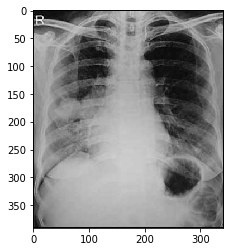

In [27]:
show_image(ip.image_dataframe_cleaned['cleaned_image'].iloc[180])

With time, the model used to detect these kinds of problems will be improved. However, at the current time, this class is still considered to be very experimental.

**Note**: Before closing out this subsection, it should be noted that several sources BioVida exposes do not require this kind of post-processing. For instance, the 'indiana_u_xray' has been assembled 'by hand' and thus is largely free of these kinds of hindrances.

---
### Train, Validation and Test

Now that we've explored data harvesting, we can turn our attention to the final step before modeling: dividing data into training, validation and tests sets.

Let's use images from the 'indiana_u_xray' collection so we can avoid the tedium of cleaning the images.

In [28]:
opi.search(collection='indiana_u_xray')


Results Found: 7,470.


The code below will download all images in this collection, which will take some time. <br>
Feel free to adjust ``download_limit`` to suit your needs.

In [29]:
pull_df2 = opi.pull(download_limit=None)


Number of Records to Download: 7,470 (chunk size: 30 records).




Extracting Features from Text...




Cleaning Text Information...

Obtaining Images... 


In [30]:
pull_df2['age'].describe()

count    38.000000
mean     15.657895
std      17.426721
min       1.000000
25%       2.250000
50%       7.000000
75%      30.000000
max      53.000000
Name: age, dtype: float64

In [31]:
pull_df2['sex'].value_counts(normalize=True)

female    0.572949
male      0.427051
Name: sex, dtype: float64

In [32]:
from biovida.images import image_divvy

First, let's inspect the data.

In [33]:
qshow(simplify_df(opi.records_db_short))

We can define a rule to construct a training and test set using a 'divvy_rule'.

In [34]:
def my_divvy_rule(row):
    if isinstance(row['diagnosis'], str):
        if 'normal' in row['diagnosis']:
            return 'normal'
        elif 'calcinosis' in row['diagnosis']:
            return 'calcinosis'

Next, we can easily split the data into an 80% train, 20% test split.

In [35]:
train_test = image_divvy(instance=opi,
                         divvy_rule=my_divvy_rule,
                         action='ndarray',
                         train_val_test_dict={'train': 0.8, 'test': 0.2})


Applying Divvy Rule...




Splitting Data...

Divvying 'normal'...

Divvying 'calcinosis'...

Structure:

- 'train':
  - 'calcinosis'
  - 'normal'
- 'test':
  - 'calcinosis'
  - 'normal'

Converting Images to ndarrays...


In [36]:
train_ca, test_ca = train_test['train']['calcinosis'], train_test['test']['calcinosis']
train_norm, test_norm = train_test['train']['normal'], train_test['test']['normal']

First we may want to look at how many samples we have.

In [37]:
# Normal
print("Train:", len(train_norm), "|", "Test:", len(test_norm))

Train: 522 | Test: 131


In [38]:
# Calcinosis
print("Train:", len(train_ca), "|", "Test:", len(test_ca))

Train: 446 | Test: 112


We can easily take a look at these images

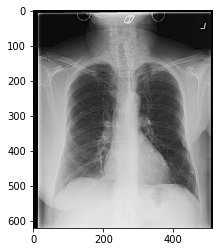

In [39]:
show_image(train_ca[30])

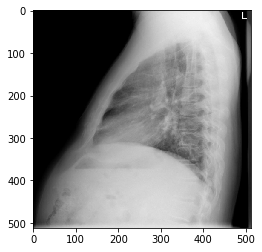

In [40]:
show_image(train_norm[99])

---

Here we've explored how ``BioVida`` can be used to easily obtain and process data from the Open-i database. <br>

In the next tutorial, we'll explore how ``BioVida`` can be used to gain access to a database with orders of magnitude more images than Open-i.



---